In [4]:
%load_ext autoreload
%autoreload 2


In [5]:
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from crops_package.data import split_data

In [7]:
data = pd.read_csv(f"{os.environ.get('DATA_PATH')}/data.csv")
data['filename'] = os.environ.get("RAW_DATA_PATH") + "/" + data['filename']
data['class'] = data['class'].astype(str)

In [8]:
train_df, val_df, test_df = split_data(data)

In [9]:
len(train_df)

18153

In [10]:
from crops_package.data import preprocessor_df
train_generator = preprocessor_df(train_df)
val_generator = preprocessor_df(val_df)

Found 18153 validated image filenames belonging to 22 classes.
Found 3204 validated image filenames belonging to 22 classes.


# Model initialization

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

def initialize_model():
    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32, (4,4), input_shape=(224, 224, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second Convolution & MaxPooling
    # model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(2, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(22, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# fit model with earlystopping

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

model_small = initialize_model()

es = EarlyStopping(patience = 5, verbose = 2)

history_small = model_small.fit(train_generator,
                    validation_data = val_generator,
                    callbacks = [es],
                    epochs = 3,
                    batch_size = 64)

Epoch 1/3
57/57 [==============================] - 24s 417ms/step - loss: 3.0839 - accuracy: 0.0937 - val_loss: 3.0770 - val_accuracy: 0.1433
Epoch 2/3
57/57 [==============================] - 20s 352ms/step - loss: 3.0698 - accuracy: 0.1064 - val_loss: 3.0642 - val_accuracy: 0.1433
Epoch 3/3
57/57 [==============================] - 20s 359ms/step - loss: 3.0568 - accuracy: 0.1064 - val_loss: 3.0527 - val_accuracy: 0.1433


In [10]:
model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 2)                 802818    
                                                                 
 dense_1 (Dense)             (None, 22)                66        
                                                                 
Total params: 804452 (3.07 MB)
Trainable params: 804452 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [80]:
model_small.save("/home/mahaut/code/MahautHDL/save_the_crops/models")

INFO:tensorflow:Assets written to: /home/mahaut/code/MahautHDL/save_the_crops/models/assets


INFO:tensorflow:Assets written to: /home/mahaut/code/MahautHDL/save_the_crops/models/assets


## Plotting History

In [11]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

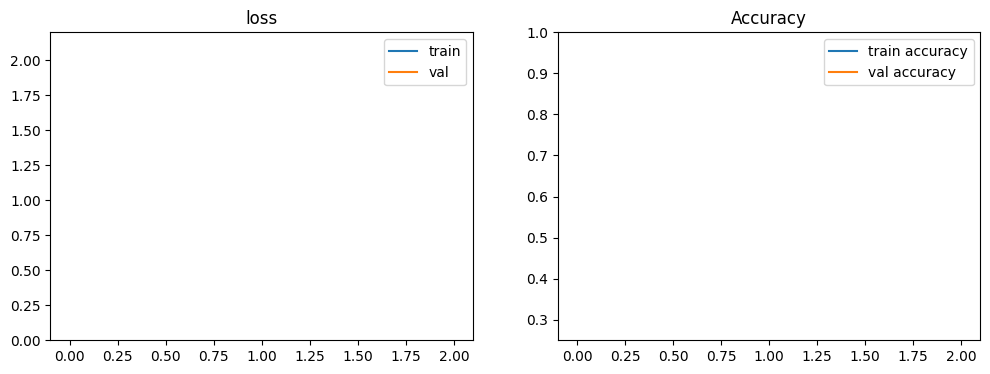

In [12]:
plot_history(history_small)
plt.show()

## EVALUATING

In [13]:
from crops_package.data import preprocessor_test

In [14]:
test_generator = preprocessor_test(test_df)

Found 377 validated image filenames belonging to 22 classes.


In [15]:
res = model_small.evaluate(test_generator, verbose = 0)
res


[3.0576109886169434, 0.07957559823989868]

## PREDICTIONS FROM A BETTER MODEL THAN THE BASIC ONE

In [2]:
from tensorflow import keras
local_model_paths = '/home/mahaut/code/MahautHDL/save_the_crops/models/first_CNN.keras'
model = keras.models.load_model(local_model_paths)

2024-03-08 22:33:21.645169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 22:33:21.649845: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 22:33:21.710461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 22:33:21.710511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 22:33:21.711994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [11]:
index = 0
filepath = list(test_df['filename'])[index]
filename = list(test_df['class'])[index]

In [14]:
from crops_package.data import prepocessor_img_from_path
img_processed = prepocessor_img_from_path(filepath)

In [16]:
predictions = model.predict(img_processed)
predictions

2024-03-08 22:36:26.487329: I external/local_xla/xla/service/service.cc:168] XLA service 0x558655223420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-08 22:36:26.487397: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-08 22:36:26.504363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


I0000 00:00:1709933786.802914   33361 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-08 22:36:26.805263: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.6190355e-15,
        0.0000000e+00, 1.0000000e+00, 8.4329679e-30, 1.0453563e-14,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [17]:
class_names = list(train_generator.class_indices.keys())
class_names


['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic',
 'Maize fall armyworm',
 'Maize grasshoper',
 'Maize healthy',
 'Maize leaf beetle',
 'Maize leaf blight',
 'Maize leaf spot',
 'Maize streak virus',
 'Tomato healthy',
 'Tomato leaf blight',
 'Tomato leaf curl',
 'Tomato septoria leaf spot',
 'Tomato verticulium wilt']

In [35]:
outcome = class_names[np.argmax(predictions)].split()
plant_name = outcome[0]
plant_disease = " ".join(outcome[1:])
plant_disease

'leaf beetle'

In [18]:
print(f"{class_names[np.argmax(predictions)]} - {np.max(predictions)* 100:.2f}%")

Maize leaf beetle - 100.00%


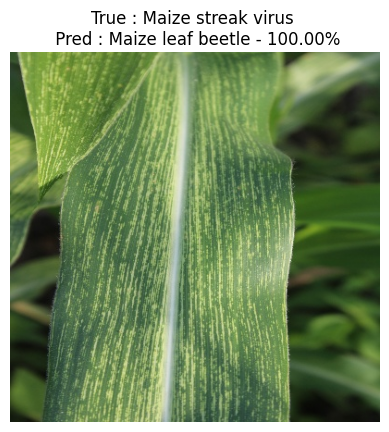

In [23]:
img = plt.imread(filepath)

plt.imshow(img)
plt.axis(False)
plt.title(f"True : {filename} \n Pred : {class_names[np.argmax(predictions)]} - {np.max(predictions)* 100:.2f}%")
plt.show()


In [24]:
external_path="https://res.cloudinary.com/compo-com/image/fetch/c_fill,g_xy_center,f_auto,w_708,h_531,x_iw_mul_50_div_100,y_ih_mul_42_div_100/https://www.compo.de/dam/jcr:0f172ae7-9fb3-4fd2-be8b-810d3582da05/sweet-corn_Maiskolben.jpg"
img2_processed = prepocessor_img_from_path(external_path)

In [26]:
predictions2 = model.predict(img2_processed)
predictions2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]], dtype=float32)

In [27]:
print(f"{class_names[np.argmax(predictions2)]} - {np.max(predictions2)* 100:.2f}%")

Cassava brown spot - 100.00%
